# Automatic data labeling with snorkel-metal

John Brandt


Last Updated: July 25, 2019

## Loading and preprocessing data

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

import re
import pickle
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.metrics import confusion_matrix, f1_score

from metal.label_model import LabelModel
from metal.analysis import lf_summary, label_coverage
from metal.label_model.baselines import MajorityLabelVoter

In [ ]:
import pandas as pd
df = pd.read_csv("../data/interim/kenya-positive.csv")
df_negative = pd.read_csv("../data/interim/kenya-neutral.csv")
df_neutral = pd.read_csv("../data/interim/kenya-positive2.csv")
df_india_positive = pd.read_csv("../data/interim/india-positive.csv")
df_india_negative = pd.read_csv("../data/interim/india-negative.csv")
df_malawi_positive = pd.read_csv("../data/interim/malawi-positive.csv")

df = df.append(df_negative, ignore_index = True)
df = df.append(df_india_positive, ignore_index = True)
df = df.append(df_india_negative, ignore_index = True)
df = df.append(df_neutral, ignore_index = True)
df = df.append(df_malawi_positive, ignore_index = True)
df.to_csv("../data/processed/gold_standard.csv", index = False)


df['label'] = range(0, len(df))
df = df[['label', 'sentences', 'class']]
df.reset_index()
df.to_csv('../data/interim/all.tsv', sep = '\t', index = False)

In [442]:
df['class'] = df['class'].map({'n' : 1, 'i' : 3, 'd' : 2})

In [443]:
df.shape

(746, 3)

In [522]:
[x for x in df['sentences'][df['class'] == 3]]

['lack of a database and information to support regional development is another major constraint. this has contributed to lack of comprehensive planning by stakeholders in the regions. therefore, supporting information and records management in the subsector will provide the necessary data to support development planning and provide investment opportunities.',
 'to contribute to efforts to reduce poverty and increase income, the subsector will promote integrated community programmes that support empowerment ventures and reduce poverty in rural areas. to achieve this, partnerships, collaboration and linkages with other stakeholders will be forged in the use of devolved funds in rural areas.',
 'the youth will be sensitized on lucrative ventures in the agricultural sector, and processing plants for value addition will be established in rural areas to provide employment opportunities for the youth and to allow them to produce agricultural raw materials. linkages between the ministry of yo

## Creating labeling functions

In [561]:
#TODO: Refine and granularize the LFs
#TODO: Go through false positives and update original labels --- Some of them are incorrect
#TODO: Look for relationships between verbs and nouns to specify implementation

ABSTAIN = 0
NEUTRAL = 1
POSITIVE = 3
NEGATIVE = 2

TYPES_OF_FUNDS = r"""\b(microfinance|micro finance|grants|bilateral|multilateral|capital|concessional|
                            results based|philanthropic|credit|carbon market|fund|investment|institutional finance|
                            budget allocation|budgetary allocation|financial assistance|micro financ|
                            funding mechanism|tax break)"""

CREATING_FUNDS = r"""\b(financial support|funded by|provide funding|mobilize|provide investment|
                        offer funds|offer incentive|will be funded|increase investment|
                        mobilization of financ|encourage investment|mobilization of financ|
                        encourage investment|facilitate investment|improving the lending|
                        raise funds|new investment|green growth|mobilising resources|earmark|
                        obtain funds|funds will be provided|additional funds|increase in investment)"""

ACCESS_FUNDS = r"""\b(access funds|access finance|mobilize finance|provide finance|establish fund)"""

REDUCE_WORDS = r'''\b(reduce cost|lower cost|remove barriers|cost reduction)'''
            
INCENTIVE = r"""\b(fund established|market connection|low transaction cost|microfinance|payment system|
                    grants|funded by|provide funding|support|
                    capital|concessional|results based|mobilize|carbon market|
                    provide investment opportunities|offer incentives|generated funds|
                    qualify for grants|budgetary allocation|credit packages|increase investment|
                    carbon credit|transfer pricing|mobilization of financ|encourage investment|
                    facilitate investment|access to finance|increased revenue|improving the lending|
                    market access|raise funds|access of|cost reduction|new investments|green growth|
                    mobilising resources|micro financing|accessing funds|institutional finance|
                    obtain funds|funds will be provided|tax free|additional funds|
                    financial incentives will)"""

NEG_WORDS = r"""\b(high transaction|barriers|levied|evasion|penalty|excise|seizure|fee|disincentive|
                    inadequate|not enough|fine|hampered|limited|insufficient|challenges|impede|lack|
                    there is not|failed|there has not been|obstacle)"""

false_pos = ['credit']

def neutral(text):
    inc = re.search(INCENTIVE, text)
    cre = re.search(TYPES_OF_FUNDS, text)
    dis = re.search(NEG_WORDS, text)
    return ABSTAIN if inc or dis or cre else NEUTRAL

def reduce(text):
    return POSITIVE if re.search(REDUCE_WORDS, text) else ABSTAIN

def contains_incentive_words(text):
    return POSITIVE if re.search(INCENTIVE, text) else ABSTAIN

def contains_negative_expressions(text):
    return NEGATIVE if re.search(NEG_WORDS, text) else ABSTAIN

def contains_funding_types(text):
    return POSITIVE if re.search(TYPES_OF_FUNDS, text) else ABSTAIN

def contains_fund_creation(text):
    return POSITIVE if re.search(CREATING_FUNDS, text) else ABSTAIN

def contains_access(text):
    return POSITIVE if re.search(ACCESS_FUNDS, text) else ABSTAIN

LFs = [
    contains_incentive_words,
    contains_funding_types,
    contains_fund_creation,
    contains_access,
    contains_negative_expressions,
    neutral,
    reduce,
]

LF_names = [
    'incentive',
    'types',
    'creation',
    'access',
    'negative',
    'neutral',
    'reduce',
]

In [562]:
def make_Ls_matrix(data, LFs):
    noisy_labels = np.empty((len(data), len(LFs)))
    for i, row in data.iteritems():
        for j, lf in enumerate(LFs):
            noisy_labels[i][j] = lf(row.lower())
    return noisy_labels

In [563]:
LF_matrix = make_Ls_matrix(df['sentences'], LFs)
gold_standard = np.array(df['class'])

In [564]:
lf_summary(sparse.csr_matrix(LF_matrix),
           Y=gold_standard,
           lf_names=LF_names)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
incentive,0,3.0,0.184987,0.130027,0.021448,73,65,0.528986
types,1,3.0,0.276139,0.134048,0.028150,124,82,0.601942
creation,2,3.0,0.049598,0.049598,0.002681,33,4,0.891892
access,3,3.0,0.002681,0.002681,0.000000,2,0,1.000000
negative,4,2.0,0.085791,0.033512,0.033512,30,34,0.468750
neutral,5,1.0,0.601877,0.002681,0.002681,426,23,0.948775
reduce,6,3.0,0.006702,0.006702,0.002681,5,0,1.000000


## Baseline and label model

In [565]:
label_model = LabelModel(k=3, seed=42)
label_model.train_model(LF_matrix,
                        Y_dev=gold_standard,
                        n_epochs=1000,
                        lr=0.001,
                        log_train_every=200)

Computing O...
Estimating \mu...
[200 epo]: TRAIN:[loss=0.051]
[400 epo]: TRAIN:[loss=0.032]
[600 epo]: TRAIN:[loss=0.016]
[800 epo]: TRAIN:[loss=0.008]
[1000 epo]: TRAIN:[loss=0.004]
Finished Training


In [566]:
scores = label_model.score((LF_matrix, gold_standard), metric=['accuracy','precision', 'recall', 'f1'])

Accuracy: 0.764
Precision: 0.949
Recall: 0.786
F1: 0.860
        y=1    y=2    y=3   
 l=1    426     2     21    
 l=2     0      0      0    
 l=3    116    37     144   


In [453]:
Y_train_ps = label_model.predict_proba(LF_matrix)
Y_snorkel = label_model.predict(LF_matrix)

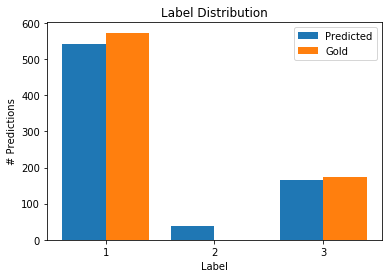

In [454]:
from metal.contrib.visualization.analysis import (
    plot_predictions_histogram, 
    plot_probabilities_histogram,
)

plot_predictions_histogram(gold_standard,
                           label_model.predict(LF_matrix),
                           title="Label Distribution")

In [559]:
false = np.where(Y_snorkel != df['class'])
#false_negatives = [x for x in false[0] if df['class'][x] == 2]
false_positives = [x for x in false[0] if df['class'][x] == 1]

In [560]:
[x for x in df['sentences'][false_positives]]

['bilateral and multilateral donors have for many years financed kenyas agricultural budget. with the countrys increased financial capacity, the role of development partners has been reduced and governments own resources are now financing over 9 0 per cent of the agricultural budget. however, development partners continue to play an important role, particularly in spearheading new initiatives and carrying out pilot projects.',
 'kenya is a member of the world trade organization. this multilateral trade system aims to expand markets through liberalizing global trade. the agriculture sector will be a key player in multilateral and bilateral trade negotiations with the objectives of expanding and diversifying agricultural products and markets. regional markets, especially the  block, are now the major destination for kenyas exports. the subsector will collaborate with other relevant sectors and subsectors to promote economic cooperation and regional integration as a strategy for expanding

## End model

In [348]:
from metal.end_model import EndModel
import torch

if torch.cuda.is_available():
    device = 'cuda'
else:
    device='cpu'
end_model = EndModel([1000,10,2], seed=123, device=device)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)



In [ ]:
X = df['sentences']

end_model.train_model((X, Y_train_ps), lr=0.01, l2=0.01, batch_size=256, 
                n_epochs=5, checkpoint_metric='accuracy', checkpoint_metric_mode='max')

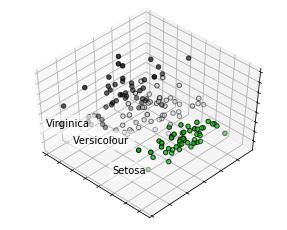

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import decomposition
from sklearn import datasets

np.random.seed(5)

centers = [[1, 1], [-1, -1], [1, -1]]
iris = datasets.load_iris()
X = iris.data
y = iris.target

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

In [8]:
X

array([[-2.68412563,  0.31939725, -0.02791483],
       [-2.71414169, -0.17700123, -0.21046427],
       [-2.88899057, -0.14494943,  0.01790026],
       [-2.74534286, -0.31829898,  0.03155937],
       [-2.72871654,  0.32675451,  0.09007924],
       [-2.28085963,  0.74133045,  0.16867766],
       [-2.82053775, -0.08946138,  0.25789216],
       [-2.62614497,  0.16338496, -0.02187932],
       [-2.88638273, -0.57831175,  0.02075957],
       [-2.6727558 , -0.11377425, -0.19763272],
       [-2.50694709,  0.6450689 , -0.07531801],
       [-2.61275523,  0.01472994,  0.10215026],
       [-2.78610927, -0.235112  , -0.20684443],
       [-3.22380374, -0.51139459,  0.06129967],
       [-2.64475039,  1.17876464, -0.15162752],
       [-2.38603903,  1.33806233,  0.2777769 ],
       [-2.62352788,  0.81067951,  0.13818323],
       [-2.64829671,  0.31184914,  0.02666832],
       [-2.19982032,  0.87283904, -0.12030552],
       [-2.5879864 ,  0.51356031,  0.21366517],
       [-2.31025622,  0.39134594, -0.239